In [26]:
import glob
import random
import os
import sys

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
from scipy.stats import zscore,kstest,stats
import seaborn as sns
from collections import OrderedDict
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#from placecode.expinfo import MultipleFilesFoundError

#import my functions
import sys
sys.path.append('..')
from placecode.spatial_coding_functions import make_firing_rate_maps,make_binary,adding_parameters,cell_morphology,TunedVector,KstestPlaceCells

In [27]:
#find the number of cells that were place in all conditions
output_file=f"D:/sd_project_pbox/results/OPI2342"
conditions=['bl_d1','bl_d2','24h_post','novel_belt_d1','novel_belt_d2','novel_belt_d3']
animals=['OPI2342',"OPI2356"]

#first store the place cells somewhere
pc_cells_fr_maps=OrderedDict()

for animal in animals:

    for condition in conditions:
        output_df_path=f'{output_file}/{condition}/output_info.h5'
        with h5py.File(output_df_path, 'r') as f:
            pc_cells_fr_maps[f'{animal}_{condition}']=f['sorted_place_cells_tuned vector']
            pc_cells_fr_maps[f'{animal}_{condition}']=np.array(pc_cells_fr_maps[f'{animal}_{condition}'])
            pc_cells_fr_maps[f'{animal}_{condition}']=pd.DataFrame(pc_cells_fr_maps[f'{animal}_{condition}'])
 

In [28]:
conditions=['bl_d1','bl_d2','24h_post','novel_belt_d1','novel_belt_d2','novel_belt_d3']
#threshold for steps to establish maximum activation
steps=20 #corresponds to 20c
belt_length=150
pc_width=OrderedDict()

for condition in conditions:
    pc_width[f'{condition}']=[]

for animal in animals:
    for condition in conditions:
        for n in range(len(pc_cells_fr_maps[f'{animal}_{condition}'])):
            place_field_activation=pc_cells_fr_maps[f'{animal}_{condition}'].iloc[n]
            max_index = np.argmax(place_field_activation)
            max_z_score = place_field_activation[max_index] #point of maximum activation
            #threshold for sifnificant activation
            threshold = max_z_score * 0.7  # 70% of the maximum z-score
            left_steps=0
            right_steps=0
            for i in range(1,steps):
                ###for right steps
                if max_index+i<belt_length:
                    if place_field_activation[max_index+i]>=threshold:
                        right_steps+=1
                if max_index+i>=belt_length:
                    if place_field_activation[max_index+i-belt_length]>=threshold:
                        right_steps+=1
                ###for left steps
                if max_index-i>=0:
                    if place_field_activation[max_index-i]>=threshold:
                        left_steps+=1
                if max_index-i<0:
                    if place_field_activation[max_index-i+belt_length]>=threshold:
                        left_steps+=1


            pc_width[condition].append(left_steps+right_steps)



C:\Users\ttami\AppData\Local\Temp\ipykernel_6616\3927580338.py:23: DeprecationWarning: Please use `f_oneway` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  f_stat, p_value = stats.f_oneway(*groups)


F-statistic: 3.837959029450963, p-value: 0.0022138530875391773
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
     24h_post         bl_d1  -1.9361 0.4367 -4.9421  1.0699  False
     24h_post         bl_d2  -0.2179    1.0 -3.4969  3.0611  False
     24h_post novel_belt_d1   0.3493 0.9998 -3.3396  4.0382  False
     24h_post novel_belt_d2  -3.4031 0.0368 -6.6821  -0.124   True
     24h_post novel_belt_d3  -2.6652 0.3683 -6.5672  1.2368  False
        bl_d1         bl_d2   1.7182  0.392 -0.8494  4.2858  False
        bl_d1 novel_belt_d1   2.2853 0.2733 -0.7885  5.3592  False
        bl_d1 novel_belt_d2   -1.467 0.5732 -4.0346  1.1006  False
        bl_d1 novel_belt_d3  -0.7291 0.9888 -4.0557  2.5975  False
        bl_d2 novel_belt_d1   0.5671 0.9966 -2.7742  3.9084  False
        bl_d2 novel_belt_d2  -3.1852 0.0207 -6.0676 -0.3028   True

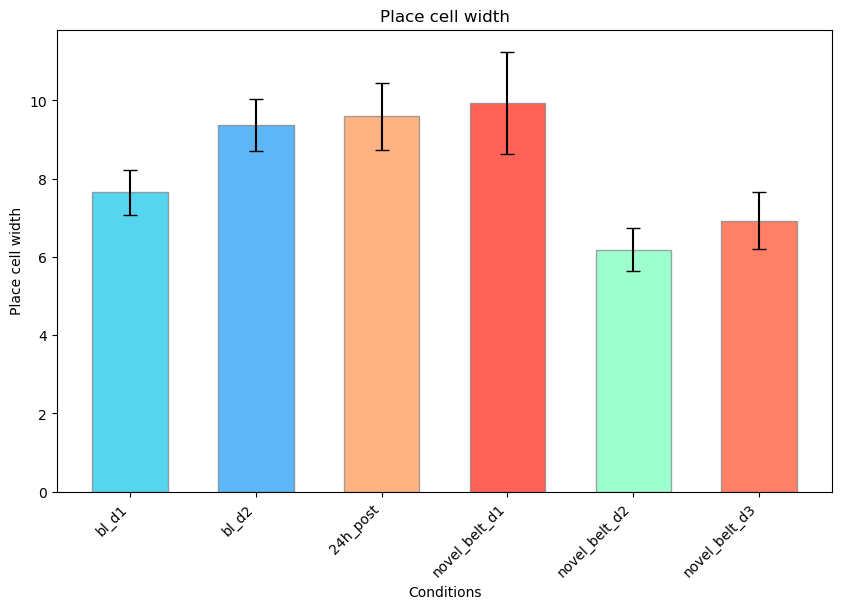

In [31]:
# Calculate means and standard deviations
labels = list(pc_width.keys())
means = [np.mean(values) for values in pc_width.values()]
std_devs = [np.std(values, ddof=1) for values in pc_width.values()]  # ddof=1 for sample std
sems = [np.std(values, ddof=1) / np.sqrt(len(values)) for values in pc_width.values()]

# Plotting
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, means, width, yerr=sems, capsize=5, alpha=0.7, ecolor='black', edgecolor='gray',color=[plt.cm.rainbow(np.random.rand()) for _ in means])

# Add labels and title
ax.set_xlabel('Conditions')
ax.set_ylabel('Place cell width')
ax.set_title('Place cell width')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

#perform anova
groups = list(pc_width.values())  # Extract the list of values for each condition
f_stat, p_value = stats.f_oneway(*groups)
print(f"F-statistic: {f_stat}, p-value: {p_value}")

#organize data in a pdanda frame
data = []
for label, values in pc_width.items():
    data.extend([(label, value) for value in values])

df = pd.DataFrame(data, columns=['Condition', 'Width'])

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Width'], groups=df['Condition'], alpha=0.05)
print(tukey)



# plt.tight_layout()
plt.show()